<a href="https://colab.research.google.com/github/sandrofonseca/2020-07-13-pyhep2020-tutorial/blob/master/pyHEP20_RPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC RPC analysis using jupyter notebooks
Sandro Fonseca de Souza (UERJ/Brazil)

## Table of contents
### Test beam campaign
1. [Set up the notebook for a test beam campaign](#Set-up-the-notebook-for-a-test-beam-campaign)
    1. [Loading data using the python environment](#Loading-data-using-the-python-environment)
    1. [Physics observables: reconstructed energy, longitudinal profiles and number of hits](#Physics-observables:-reconstructed-energy,-longitudinal-profiles-and-number-of-hits)
1. [Data Quality Monitoring (DQM): Event displays and preliminary sanity checks ](#Data-Quality-Monitoring-(DQM):-Event-displays-and-preliminary-sanity-checks)
    1. [Event display: a first taste of data](#Event-display:-a-first-taste-of-data)
    1. [DAQ: High vs low gain amplitudes](#DAQ:-High-vs-low-gain-amplitudes)
    1. [The result of DQM studies: spotting and masking bad features in Data](#The-result-of-DQM-studies:-spotting-and-masking-bad-features-in-Data)
1. [Effect of DQM studies on physics observables](#Effect-of-DQM-studies-on-physics-observables)

### Statystical data analysis
1. [Offline analysis: from reconstructed data to the final results](#Offline-analysis:-from-reconstructed-data-to-the-final-results)
    1. [Inputs for the statistical analysis: large amount of data](#Inputs-for-the-statistical-analysis:-large-amount-of-data)
1. [Measuring the energy resolution](#Measuring-the-energy-resolution)
    1. [Jupyter notebooks from top to bottom: the final result](#Jupyter-notebooks-from-top-to-bottom:-the-final-result)

## Set up the notebook 

In [ ]:
import os
os.system('/opt/exp_soft/cms/t3/eos-login -init -username sfonseca')

32512

In [ ]:
import uproot
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

url = 'https://gist.githubusercontent.com/bonanomi/d14780f7562cb2a22fdd753a9d4459d4/raw/0bc42ffb18bdf8bf47bcd506244cc23aa32d70d6/MyMPLStyle'

plt.style.use(url)

In [ ]:
url = 'https://gist.githubusercontent.com/bonanomi/d14780f7562cb2a22fdd753a9d4459d4/raw/0bc42ffb18bdf8bf47bcd506244cc23aa32d70d6/MyMPLStyle'

plt.style.use(url)

### Loading data using the python environment

Most importantly, during a test beam campaign we collect a huge amount of data (e.g. in the October 2018 TB at CERN, a total of $\sim 10^6$ data were collected) and we want to have fast access to them, without the need of downloading everything to a local machine.

This allows us to perform some basic data visualization operations (i.e. *data quality monitoring*), to ensure the overall good quality of the data and to spot problematic features, in order to intervene immediately or to take them into account at the level of statistical analysis.

In [ ]:

sim_prefix = '/eos/user/s/sfonseca/cscrpcNtuples/Mu_FlatPt2to100-pythia8-gun/crab_cscrpc_MC_analysis/200610_204431/0000/'

The most famous file format in HEP is probably `.root`, designed specifically for the [`ROOT`](https://root.cern.ch/) data analysis framework. However, during the years, more and more `python` based packages have been made available to handle the I/O of `.root`-like files exploiting the versatility of the `python` ecosystem.

[`uproot`](https://github.com/scikit-hep/uproot) is a reader and a writer of the ROOT file format using only Python and Numpy. In the following we dump our `.root` files into `pandas` dataframes. Let us define an helper function for this purpose:

## CSC Branches

In [ ]:
def do_df_csc(run, location, isMC=True, withDWC=False):
    branches = [u'cscIDEndcap', 'cscIDRing', 'cscIDStation', 'cscIDChamber',
                u'CSCGlobalPosition_X', 'CSCGlobalPosition_Y', 'CSCGlobalPosition_Z','impactCSCPeakTime2nd','impactCSCPeakTimeAverage']
    #if isMC:
    #    branches.append(u'ahc_energySum')

    rh_branches = [branch for branch in branches if 'csc' in branch]

    fname = location + 'output_%i.root' %run
    #if isMC:
    #    fname = location + 'ntuple_sim_config22_pdgID11_beamMomentum%i_listFTFP_BERT_EMN_0000_0.root' %run
        
    key='dumpcsc/cscrpc'
    df = uproot.open(fname)[key].pandas.df(branches, entrystart = 0, entrystop = 6)
    df = df.reset_index(level=1,drop=True)
    df.index.names = ['impactEventId']
    
    return df

In [ ]:
df_mc_csc = do_df_csc(1, sim_prefix, isMC = True)

In [ ]:
df_mc_csc.head()

,cscIDEndcap,cscIDRing,cscIDStation,cscIDChamber,CSCGlobalPosition_X,CSCGlobalPosition_Y,CSCGlobalPosition_Z,impactCSCPeakTime2nd,impactCSCPeakTimeAverage
impactEventId,,,,,,,,,
0,0,0,0,0,-642.687378,42.013577,695.353333,-7.599411,0.771364
0,0,0,0,0,629.172729,-123.560333,-695.038818,-7.599411,0.771364
1,0,0,0,0,-642.687378,42.013577,695.353333,-7.599411,0.771364
1,0,0,0,0,629.172729,-123.560333,-695.038818,-7.599411,0.771364
2,0,0,0,0,-642.687378,42.013577,695.353333,-7.599411,0.771364


## RPC Branches

In [ ]:
def do_df_rpc(run, location, isMC=True, withDWC=False):
    branches = [u'rpcIDRegion', 'rpcIDRing', 'rpcIDStation', 'rpcChamberID','rpcIDRoll',
                u'RPCGlobalPosition_X', 'RPCGlobalPosition_Y', 'RPCGlobalPosition_Z','impactConeRadiusX','impactConeRadiusY',
                u'impactDistanceZ','impactRPCBX','impactRPC','impactGlobalPosition_X','impactGlobalPosition_Y',
                u'impactLocalPosition_X','impactLocalPosition_Y','impactAngle','impactStrip','impactResidual','impactClusterSize']
    #if isMC:
    #    branches.append(u'ahc_energySum')

    rh_branches = [branch for branch in branches if 'rpc' in branch]

    fname = location + 'output_%i.root' %run
    #if isMC:
    #    fname = location + 'ntuple_sim_config22_pdgID11_beamMomentum%i_listFTFP_BERT_EMN_0000_0.root' %run
        
    key='dumpcsc/cscrpc'
    df = uproot.open(fname)[key].pandas.df(branches, entrystart = 0, entrystop = 6)
    df = df.reset_index(level=1,drop=True)
    df.index.names = ['impactEventId']
    
    return df

In [ ]:
df_mc_rpc = do_df_rpc(1, sim_prefix, isMC = True)

In [ ]:
df_mc_rpc.head()

,rpcIDRegion,rpcIDRing,rpcIDStation,rpcChamberID,rpcIDRoll,RPCGlobalPosition_X,RPCGlobalPosition_Y,RPCGlobalPosition_Z,impactConeRadiusX,impactConeRadiusY,...,impactRPCBX,impactRPC,impactGlobalPosition_X,impactGlobalPosition_Y,impactLocalPosition_X,impactLocalPosition_Y,impactAngle,impactStrip,impactResidual,impactClusterSize
impactEventId,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,-665.852417,42.520927,719.799988,0.0,-2.837344,...,0,637588104,648.548706,-127.439209,12.88382,-0.524645,0.770425,19.565586,-0.226944,3
0,0,0,0,0,0,648.548706,-127.439209,-715.400024,0.0,-2.837344,...,0,637588104,648.548706,-127.439209,12.88382,-0.524645,0.770425,19.565586,-0.226944,3
1,0,0,0,0,0,-665.852417,42.520927,719.799988,0.0,-2.837344,...,0,637588104,648.548706,-127.439209,12.88382,-0.524645,0.770425,19.565586,-0.226944,3
1,0,0,0,0,0,648.548706,-127.439209,-715.400024,0.0,-2.837344,...,0,637588104,648.548706,-127.439209,12.88382,-0.524645,0.770425,19.565586,-0.226944,3
2,0,0,0,0,0,-665.852417,42.520927,719.799988,0.0,-2.837344,...,0,637588104,648.548706,-127.439209,12.88382,-0.524645,0.770425,19.565586,-0.226944,3


## Data Quality Monitoring (DQM): Event displays and preliminary sanity checks 

As a very first step, we can check some *events display*: these give us a quick hint on the general quality of our data and can be used to detect "by eye" striking wrong features that could have affected the reconstruction. They also are a great way to visually represent the electromagnetic shower's propagation in the calorimeter.

In [ ]:
def evt_display(df, event):
    
    cmap = 'viridis'

    x = df_xyz.rechit_x
    y = df_xyz.rechit_y
    z = df_xyz.rechit_layer

    c = df_xyz.rechit_z
    s = np.sqrt(df_xyz.rechit_energy)*5
    
    fig = plt.figure(figsize = (10,8))
    ax1 = fig.add_subplot(221, projection='3d')
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    m_style = 'o'
    ax1.scatter(x, z, y, c = c, s = s, marker = m_style, cmap = cmap)
    ax2.scatter(z, x, c = c, s = s, marker = m_style, cmap = cmap)
    ax3.scatter(z, y, c = c, s = s, marker = m_style, cmap = cmap)
    m_style = 'H'
    ax4.scatter(x, y, c = c, s = s, marker = m_style, cmap = cmap)

    ax1.set_xlabel('x [cm]', fontsize = 10); ax1.set_ylabel('layer', fontsize = 10); ax1.set_zlabel('y [cm]', fontsize = 10)
    ax2.set_xlabel('layer', fontsize = 10); ax2.set_ylabel('x [cm]', fontsize = 10)
    ax3.set_xlabel('layer', fontsize = 10); ax3.set_ylabel('y [cm]', fontsize = 10)
    ax4.set_xlabel('x [cm]', fontsize = 10); ax4.set_ylabel('y [cm]', fontsize = 10)

    ax4.set_ylim(-20,20)
    ax4.set_xlim(-30,30)

    ax1.set_xlim(-15,15)
    ax1.set_zlim(-15,15)
    ax1.set_ylim(0,40)
    
    ax1.set_title('Event %i' % event, fontsize = 10)

### Event display: a first taste of data

We just select a random event from our dataframe and we look its *event display*, i.e. the distribution of our reconstructed hits in the calorimeter for the x and y coordinates, as a function of the layer number. To do so, we use the basic features of `matplotlib` to create a `scatter` plot. 

This is a quick and dirty way of checking that everything went fine during our data taking and to qualitatively assess the goodness of the reconstruction algorithms used. 

In [ ]:
event = 190
df_xyz = df.loc[event]

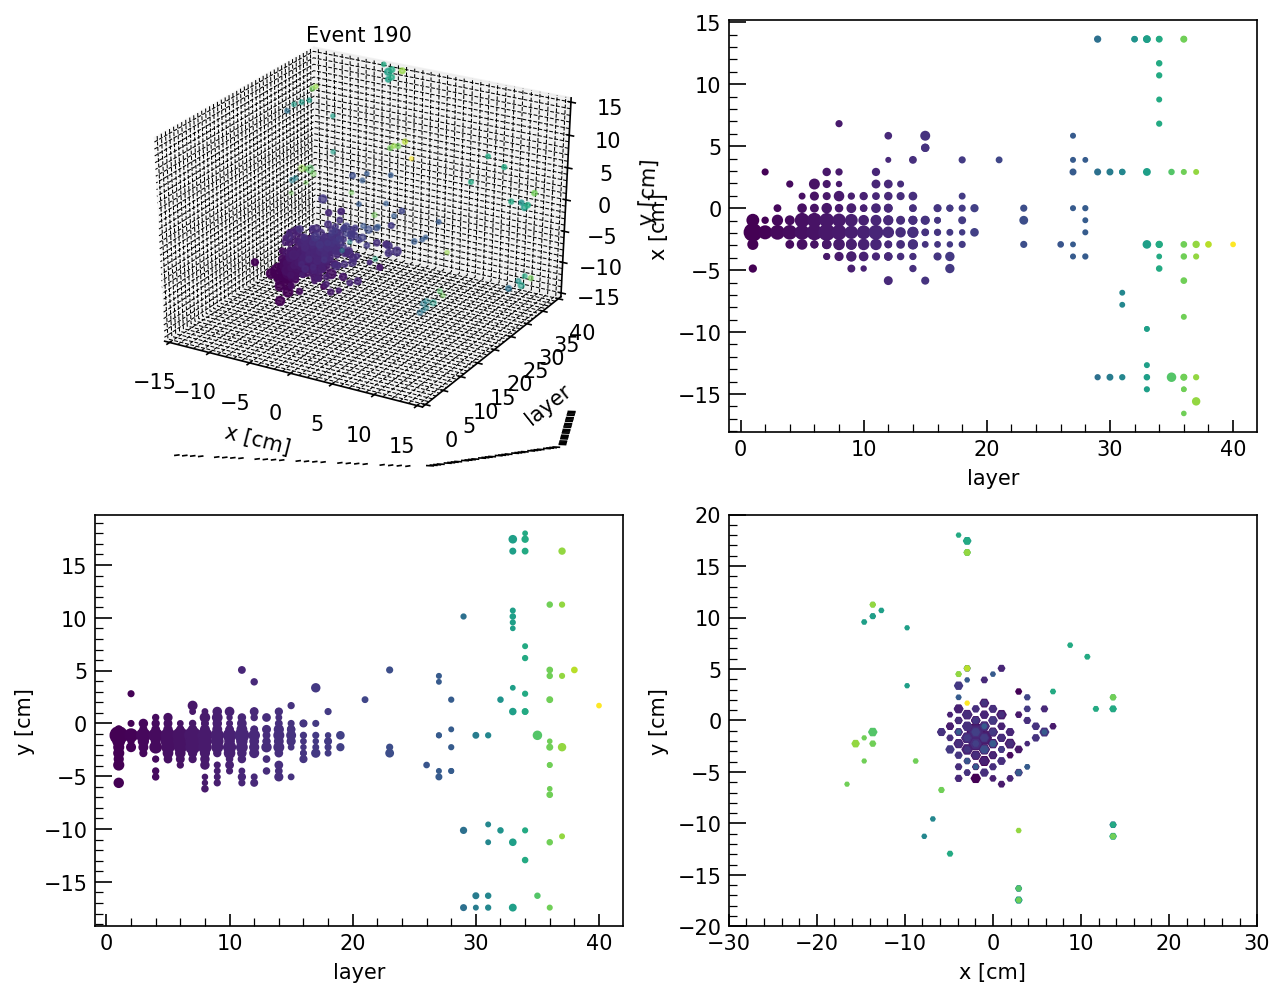

In [ ]:
evt_display(df_xyz, event)